<a href="https://colab.research.google.com/github/jdweitz/autoencoder-anomaly-detection/blob/main/Olympic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/AE/Sparse_AE/LHC_data/'

from torch.utils.data import random_split, Dataset, DataLoader
import pandas as pd

import numpy as np
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, mean_absolute_error
import torch.nn.utils.prune as prune
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

Mounted at /content/drive


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Data Loading

In [35]:
def compute_mean_std(data):
    # Compute mean and std column-wise
    means = data.mean(axis=0)
    std_devs = data.std(axis=0)
    return means, std_devs

class AllDatasets(Dataset):
    def __init__(self, filename, label, train=True, mean=None, std=None):

        with h5py.File(filename, "r") as input:
            # Get relative pt, eta, and phi for constituents
            data = input["constituents_padded"][:, :, :, 6:9].reshape(-1, 60).astype(np.float32)
            # Get pt, eta, and phi for jets
            #jet_data = input["jets_padded"][:, :, 3:6].reshape(-1, 6).astype(np.float32)
            #data = np.concatenate((constituent_data, jet_data), axis=1)
            labels = input["labels"][:]
            self.data = torch.tensor(data[labels == label], dtype=torch.float32)

            # Split the data for both train and test
            X_train, X_test = train_test_split(self.data, test_size=0.5, shuffle=True)

            if train:
                self.data = torch.tensor(X_train, dtype=torch.float32)
                # Compute mean and std only for training data
                self.mean, self.std = compute_mean_std(self.data)
            else:
                if mean is None or std is None:
                    raise ValueError("For test set, mean and std must be provided.")
                self.mean, self.std = mean, std
                self.data = torch.tensor(X_test, dtype=torch.float32)  # Use the test portion of the data

        # Normalize
        self.data = (self.data - self.mean) / self.std

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_point = self.data[idx]
        return data_point

def get_dataloaders(path, BATCH_SIZE=1024):
    fn = path + "relative_constituents_rd_dataset.h5"

    bkg_train_data = AllDatasets(fn, label=0, train=True)
    bkg_test_data = AllDatasets(fn, label=0, train=False, mean=bkg_train_data.mean, std=bkg_train_data.std)
    two_prong_data = AllDatasets(fn, label=1, train=False, mean=bkg_train_data.mean, std=bkg_train_data.std)
    three_prong_data = AllDatasets(fn, label=2, train=False, mean=bkg_train_data.mean, std=bkg_train_data.std)

    # Create the dataloaders
    bkg_trainloader = DataLoader(bkg_train_data, batch_size=BATCH_SIZE, shuffle=True)
    bkg_testloader = DataLoader(bkg_test_data, batch_size=BATCH_SIZE, shuffle=False)
    two_prong_loader = DataLoader(two_prong_data, batch_size=BATCH_SIZE, shuffle=True)
    three_prong_loader = DataLoader(three_prong_data, batch_size=BATCH_SIZE, shuffle=True)

    return bkg_trainloader, bkg_testloader, two_prong_loader, three_prong_loader

In [36]:
fn = path + "relative_constituents_rd_dataset.h5"

bkg_trainloader, bkg_testloader, two_prong_loader, three_prong_loader = get_dataloaders(path)

<ipython-input-35-e0c2406a6572>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-35-e0c2406a6572>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(X_test, dtype=torch.float32)  # Use the test portion of the data


# Check Means and Standard Deviations

In [5]:
def compute_mean_std_for_loader(loader):
    data_list = []

    for data in loader:
        data_list.append(data)

    # Stack the data
    all_data = torch.cat(data_list, dim=0)

    # Compute mean and std
    mean = torch.mean(all_data, dim=0)
    std = torch.std(all_data, dim=0)

    return mean, std

In [6]:
means, std_devs = compute_mean_std_for_loader(bkg_trainloader)
print(means, std_devs)

tensor([ 2.1177e-07,  1.0803e-08,  1.3313e-08, -4.7122e-07, -2.8992e-10,
         1.2691e-08,  3.1207e-07, -1.1383e-08,  5.6038e-09,  4.6837e-08,
         3.7041e-09, -5.6667e-09,  3.3374e-07,  1.1749e-09, -1.5618e-08,
        -1.7088e-07,  3.2005e-09,  9.3050e-09,  1.9003e-07, -1.3313e-08,
         1.2347e-08,  6.8768e-07, -7.8011e-09, -3.9101e-09,  3.8433e-07,
        -7.0190e-10, -1.8024e-09, -5.2956e-08,  1.3287e-08,  5.9452e-09,
         3.7783e-07,  6.3810e-09, -1.1900e-08, -3.3334e-08,  6.1550e-09,
        -1.7230e-08, -4.0486e-07,  8.6079e-09, -1.7052e-08, -6.6046e-07,
        -5.5122e-09, -1.9311e-08,  5.3273e-07, -9.2592e-09,  1.3166e-08,
         4.1874e-08,  5.7535e-09,  1.2249e-08,  6.1720e-07,  3.2692e-09,
         1.3821e-08, -2.1042e-07,  1.3808e-08, -2.2243e-08, -9.2054e-08,
         2.6622e-09, -1.8663e-09, -6.7516e-07, -3.9721e-09,  9.4948e-09,
        -2.1724e-07, -1.2222e-08,  1.1878e-08,  7.7066e-07, -3.7766e-09,
         2.3804e-09]) tensor([1.0000, 1.0000, 1.000

# Methods

In [37]:
# returns tpr value for specific threshold
# signal_losses is a tensor of individual losses for a given signal dataset
def get_tpr(threshold, signal_losses):
    tpr = torch.sum(signal_losses > threshold).float() / len(signal_losses)
    return tpr

# retruns threshold given an fpr
def get_threshold(fpr, background_losses):
    background_losses = background_losses.sort()[0] # Use PyTorch's sort function and pick values
    num_false_pos = int(len(background_losses) * fpr)
    threshold = background_losses[-num_false_pos]
    return threshold

#exponential linespace because we have a large threshold space to cover
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power)

def batch_MSE(input, output):
    loss = torch.mean(torch.pow(input - output, 2), dim = 1)
    return loss

def mae_loss(input, output):
    return torch.mean(torch.abs(input - output))

def batch_MAE(input, output):
    loss = torch.mean(torch.abs(input - output), dim=1)
    return loss

def get_losses(model, dataloader):
    model.eval()
    criterion = batch_MSE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    with torch.no_grad():
        for data in dataloader:
            data = data.float().to(device)
            outputs = model(data)
            losses = criterion(data, outputs)
            results.append(losses)
    return torch.cat(results, 0)

def print_tprs(background_losses, signal_losses, fpr = 1e-5):
    threshold = get_threshold(fpr, background_losses)
    tpr = get_tpr(threshold, signal_losses)
    print(f"{tpr.item():.7f}")

def plot_auc(background_losses, list_of_signal_losses, list_of_signal_labels, num_fprs=100):
    fprs = powspace(5e-6, 1, 5, num_fprs)

    for signal_losses, signal_label in zip(list_of_signal_losses, list_of_signal_labels):
        tprs = torch.zeros(num_fprs)
        for fpr_idx, fpr in enumerate(fprs):
            threshold = get_threshold(fpr, background_losses)
            tpr = get_tpr(threshold, signal_losses)
            tprs[fpr_idx] = tpr

        # Plot curve for the current signal dataset
        plt.plot(fprs, tprs.numpy(), label=f'{signal_label}, auc: {round(auc(fprs, tprs.numpy()), 2)}')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
    plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
    plt.title("Constituent and Jet (pt, eta, phi) ROC AE")

    plt.show()

# Normalized number of events for plotting:
def plot_histogram(background_losses, list_of_signal_losses, list_of_signal_labels, bin_size):
    # Make sure the number of signal loss tensors matches the number of labels
    assert len(list_of_signal_losses) == len(list_of_signal_labels), "Mismatch between number of signals and labels"

    # Calculate the total number of events
    total_events = background_losses.size(0) + sum([loss.size(0) for loss in list_of_signal_losses])

    plt.figure(figsize=(10,8))

    # Weights for the background
    background_weights = np.ones_like(background_losses.cpu().numpy()) * background_losses.size(0) / total_events

    plt.hist(background_losses.cpu().numpy(), bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label='background', weights=background_weights)

    # Now, iterate through each signal and plot it
    for signal_losses, label in zip(list_of_signal_losses, list_of_signal_labels):
        signal_weights = np.ones_like(signal_losses.cpu().numpy()) * signal_losses.size(0) / total_events
        plt.hist(signal_losses.cpu().numpy(), bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label=label, weights=signal_weights)

    plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("Autoencoder Loss")
    plt.ylabel("Probability (a.u.)")
    plt.title('Constituent and Jet (pt, eta, phi) MSE loss')
    plt.legend()
    plt.show()

def get_latent_representations(dataloader, model):
    latent_representations = []

    for batch_data in dataloader:
        with torch.no_grad():
            latent = model.encoder(batch_data).numpy()
            latent_representations.append(latent)

    return np.concatenate(latent_representations, axis=0)

In [38]:
class Autoencoder(nn.Module):
    def __init__(self, input_size = 60, latent_dim=2, dropout_rate=0):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(input_size),
            self._init_weights(nn.Linear(input_size, 16)),
            #nn.BatchNorm1d(16),
            nn.LeakyReLU(0.3),
            nn.Dropout(dropout_rate),
            # self._init_weights(nn.Linear(32, 8)),
            # nn.LeakyReLU(0.3),
            # nn.Dropout(dropout_rate),
            # self._init_weights(nn.Linear(16, 8)),
            # nn.LeakyReLU(0.3),
            # nn.Dropout(dropout_rate),
            self._init_weights(nn.Linear(16, latent_dim))
        )
        # Decoder
        self.decoder = nn.Sequential(
            self._init_weights(nn.Linear(latent_dim, 16)),
            #nn.BatchNorm1d(16),
            nn.LeakyReLU(0.3),
            # self._init_weights(nn.Linear(8, 16)),
            # nn.LeakyReLU(0.3),
            # self._init_weights(nn.Linear(8, 32)),
            # nn.LeakyReLU(0.3),
            self._init_weights(nn.Linear(16, input_size))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def _init_weights(self, layer): # implemented this to mimic the HeUniform in tf model
        nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)
        return layer

def train(model, train_loader, num_epochs, lr = 0.001, early_stopping_patience=10, get_losses = False, val_loader = None):
    # Init training optimizers
    optimizer = optim.Adam(model.parameters(), lr = lr)
    #optimizer = optim.Adagrad(model.parameters(), lr=lr)
    #scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2, verbose=True, min_lr=1E-6)
    criterion = nn.MSELoss()
    #criterion = mae_loss

    best_model_state = None  # Save the best model's state dict here

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    device = next(model.parameters()).device # added for cuda

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            data = data.to(device)  # ensure data is on the same device as the model (added for cuda)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(data, outputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print('epoch [{}/{}], Training loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss / len(train_loader)))
        if get_losses == True:
            val_loss = test(model, val_loader)
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss)

            # Call the scheduler step with the current validation loss
            scheduler.step(val_loss)

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(model.state_dict())  # Update best model state
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered after {} epochs".format(epoch + 1))
                model.load_state_dict(best_model_state)  # Revert to best model state
                break

    if get_losses == True:
        return train_losses, val_losses

def test(model, dataloader):
  # Testing the autoencoder
  model.eval()
  criterion = nn.MSELoss()
  #criterion = mae_loss
  test_loss = 0
  with torch.no_grad():
      for data in dataloader:
          data = data.to(device)  # Move data to the device that the model is on
          outputs = model(data)
          loss = criterion(data, outputs)
          test_loss += loss.item()

  test_loss = test_loss / len(dataloader)

  print('Loss: {:.4f}'.format(test_loss))
  return test_loss

In [39]:
def get_parameters_to_prune(model):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    return tuple(parameters_to_prune)

def sparsity_print(model):
    prune.global_unstructured(get_parameters_to_prune(model),pruning_method=prune.L1Unstructured,amount=0)
    zero = total = 0
    for module, _ in get_parameters_to_prune(model):
        zero += float(torch.sum(module.weight == 0))
        total += float(module.weight.nelement())
    print('Number of Zero Weights:', zero)
    print('Total Number of Weights:', total)
    print('Sparsity', zero/total)
    return zero, total

def layerwise_sparsity_print(model):
    parameters_to_prune = get_parameters_to_prune(model)

    for idx, (module, _) in enumerate(parameters_to_prune):
        zero = float(torch.sum(module.weight == 0))
        total = float(module.weight.nelement())

        print(f'Layer {idx + 1} Sparsity: {zero / total:.2%}')
        print(f'Layer {idx + 1} Number of Zero Weights:', zero)
        print(f'Layer {idx + 1} Total Number of Weights:', total)
        print("-----------------------------")

    total_zero = sum([float(torch.sum(module.weight == 0)) for module, _ in parameters_to_prune])
    total_weights = sum([float(module.weight.nelement()) for module, _ in parameters_to_prune])

    print('Overall Number of Zero Weights:', total_zero)
    print('Overall Total Number of Weights:', total_weights)
    print('Overall Sparsity:', total_zero / total_weights)

    return total_zero, total_weights

def Prune(model, train_loader, val_loader, pruning_iters = 30, num_epochs = 60, amount = .2, delay_pruning_epochs = 0):
    zeros = [] #keeps track of zeros at each iteration
    tprs = [] #keeps track of tpr at each pruning iteration
    train_losses = [] #keeps track of training loss at each pruning iteration
    val_losses = [] #keeps track of validation loss at each pruning iteration
    background_losses_all = [] #keeps track of background losses at each pruning iteration
    two_signal_losses = [] #keeps track of signal losses at each pruning iteration
    three_signal_losses = []
    fpr_target = 0.00001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Create rewind point for model
    model_rewind = copy.deepcopy(model).to(device)

    #Pretrain model before pruning
    train_loss, val_loss = train(model, train_loader, num_epochs = num_epochs, get_losses = True, val_loader = val_loader)

    # Compute background and signal losses after training
    background_losses = get_losses(model, bkg_testloader)
    twop_losses = get_losses(model, two_prong_loader)
    threep_losses = get_losses(model, three_prong_loader)

    background_losses_all.append(background_losses)
    two_signal_losses.append(twop_losses)
    three_signal_losses.append(threep_losses)

    #Lottery Ticket Rewinding: Prune, Rewind, Train
    for i in range(pruning_iters):
        print('Pruning Iteration:', i+1)
        #Prune
        prune.global_unstructured(get_parameters_to_prune(model),pruning_method=prune.L1Unstructured,amount=amount)
        #Rewind Weights
        for idx, (module, _) in enumerate(get_parameters_to_prune(model)):
            with torch.no_grad():
                module_rewind = get_parameters_to_prune(model_rewind)[idx][0]
                module.weight_orig.copy_(module_rewind.weight.to(device)) # Ensure that module_rewind.weight is on the correct device
        #Train Weights
        train_loss, val_loss = train(model, train_loader, num_epochs = num_epochs, get_losses = True, val_loader = val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Compute background and signal losses after training
        background_losses = get_losses(model, bkg_testloader)
        twop_losses = get_losses(model, two_prong_loader)
        threep_losses = get_losses(model, three_prong_loader)

        background_losses_all.append(background_losses)
        two_signal_losses.append(twop_losses)
        three_signal_losses.append(threep_losses)

        #Log Results
        zero, total = sparsity_print(model)
        zeros.append(zero)

    return train_losses, val_losses, zeros, total, background_losses_all, two_signal_losses, three_signal_losses

# Run

In [40]:
# Run training script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
train_losses, val_losses = train(model, bkg_trainloader, num_epochs = 10, lr = .001, get_losses = True, val_loader = bkg_testloader)

epoch [1/10], Training loss:1.6199
Loss: 0.9912
epoch [2/10], Training loss:0.9546
Loss: 0.9269
epoch [3/10], Training loss:0.8945
Loss: 0.8613
epoch [4/10], Training loss:0.8479
Loss: 0.8393
epoch [5/10], Training loss:0.8350
Loss: 0.8309
epoch [6/10], Training loss:0.8285
Loss: 0.8261
epoch [7/10], Training loss:0.8246
Loss: 0.8230
epoch [8/10], Training loss:0.8222
Loss: 0.8210
epoch [9/10], Training loss:0.8205
Loss: 0.8197
epoch [10/10], Training loss:0.8196
Loss: 0.8189


In [ ]:
#train_losses, val_losses = train(model, bkg_trainloader, num_epochs = 40, lr = .0001, get_losses = True, val_loader = bkg_testloader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
train_losses, val_losses, zeros, total, background_losses_all, two_signal_losses, three_signal_losses = Prune(model, bkg_trainloader, bkg_testloader, pruning_iters = 5, num_epochs = 15, amount = .2, delay_pruning_epochs=0)

In [33]:
background_losses = get_losses(model, bkg_testloader)
twop_losses = get_losses(model, two_prong_loader)
threep_losses = get_losses(model, three_prong_loader)
print_tprs(background_losses, twop_losses, fpr = 1e-5)
print_tprs(background_losses, threep_losses, fpr = 1e-5)

0.0000200
0.0000000


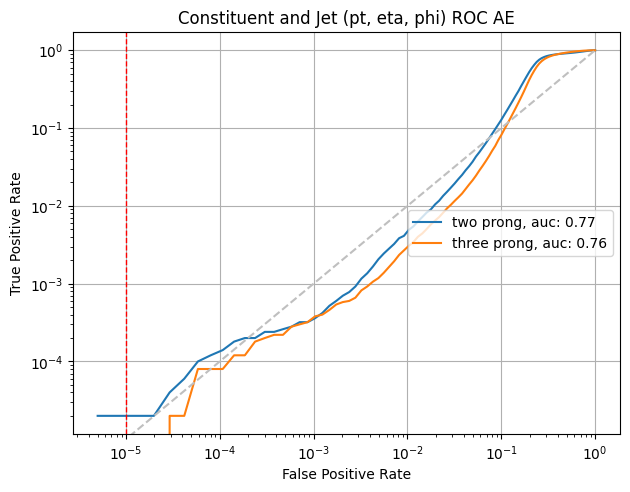

In [41]:
plot_auc(background_losses, [twop_losses, threep_losses], ['two prong', 'three prong'])

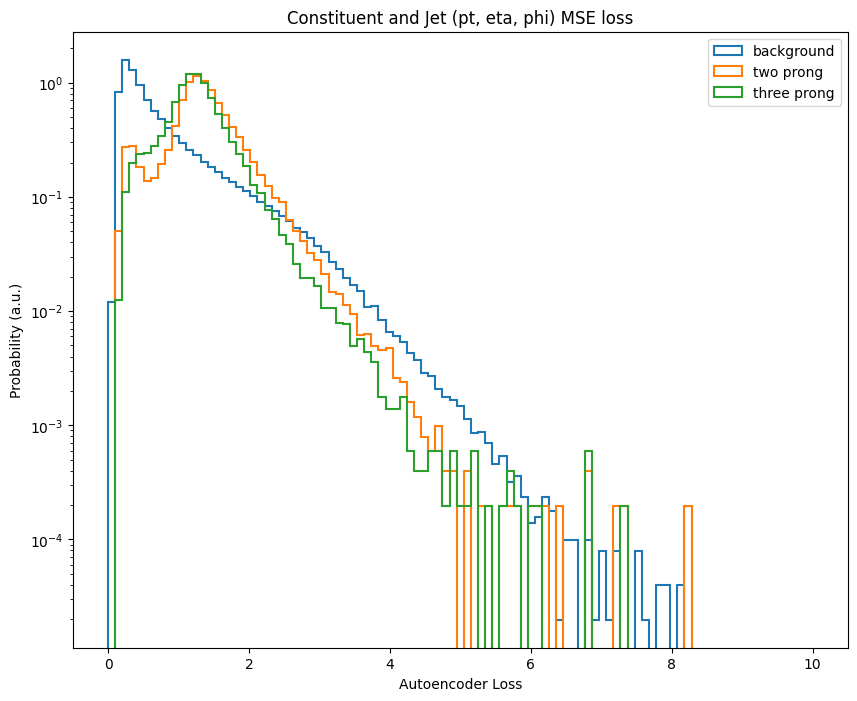

In [44]:
plot_histogram(background_losses, [twop_losses, threep_losses], ['two prong', 'three prong'], bin_size = np.linspace(0, 10, 100))

# Latent Space Visualization

In [45]:
background_latent = get_latent_representations(bkg_testloader, model)
two_prong_latent = get_latent_representations(two_prong_loader, model)
three_prong_latent = get_latent_representations(three_prong_loader, model)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


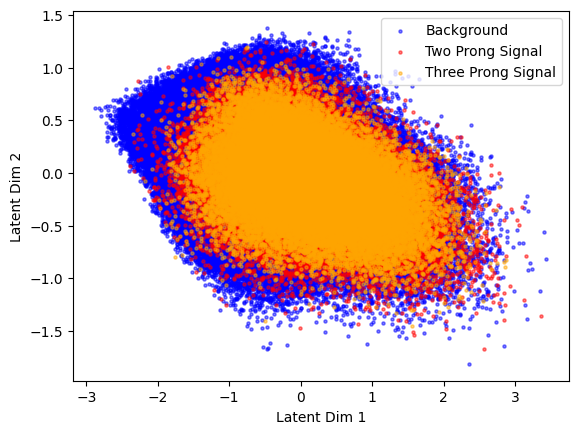

In [46]:
# Plot background latent space
plt.scatter(background_latent[:, 0], background_latent[:, 1], c='blue', alpha=0.5, label='Background', s=5)

# Plot signal latent space
plt.scatter(two_prong_latent[:, 0], two_prong_latent[:, 1], c='red', alpha=0.5, label='Two Prong Signal', s=5)

# Plot signal latent space
plt.scatter(three_prong_latent[:, 0], three_prong_latent[:, 1], c='orange', alpha=0.5, label='Three Prong Signal', s=5)

plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.legend()
plt.show()

In [ ]:
layerwise_sparsity_print(model)

Layer 1 Sparsity: 0.00%
Layer 1 Number of Zero Weights: 0.0
Layer 1 Total Number of Weights: 18.0
-----------------------------
Layer 2 Sparsity: 0.00%
Layer 2 Number of Zero Weights: 0.0
Layer 2 Total Number of Weights: 6.0
-----------------------------
Layer 3 Sparsity: 0.00%
Layer 3 Number of Zero Weights: 0.0
Layer 3 Total Number of Weights: 6.0
-----------------------------
Layer 4 Sparsity: 0.00%
Layer 4 Number of Zero Weights: 0.0
Layer 4 Total Number of Weights: 18.0
-----------------------------
Overall Number of Zero Weights: 0.0
Overall Total Number of Weights: 48.0
Overall Sparsity: 0.0


(0.0, 48.0)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


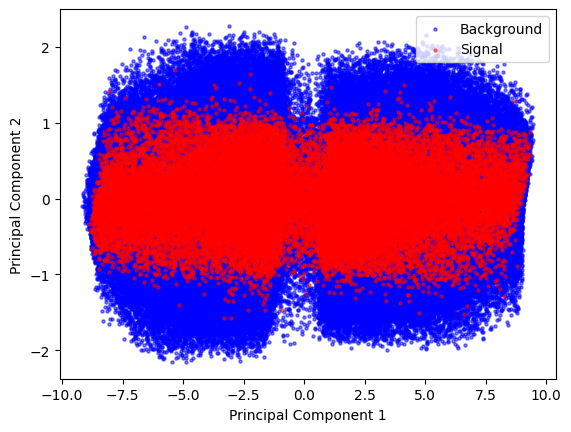

In [ ]:
# If latent space is more than 2D:

from sklearn.decomposition import PCA

# Combine datasets
all_data = np.vstack([background_latent, two_prong_latent])

# Apply PCA
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(all_data)

# Split the transformed data
background_transformed = transformed_data[:len(background_latent)]
signal_transformed = transformed_data[len(background_latent):]

# Plot the PCA transformed data
plt.scatter(background_transformed[:, 0], background_transformed[:, 1], c='blue', alpha=0.5, label='Background', s=5)
plt.scatter(signal_transformed[:, 0], signal_transformed[:, 1], c='red', alpha=0.5, label='Signal', s=5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Print Checks

In [ ]:
print(min(background_losses), max(background_losses))
print(min(twop_losses), max(twop_losses))
print(min(threep_losses), max(threep_losses))

tensor(0.0001, device='cuda:0') tensor(1.7345, device='cuda:0')
tensor(0.0005, device='cuda:0') tensor(1.1479, device='cuda:0')
tensor(0.0006, device='cuda:0') tensor(1.4258, device='cuda:0')


In [ ]:
print(len(background_losses))

500000


In [ ]:
print(threshold)

NameError: ignored

In [ ]:
torch.sum(twop_losses > threshold)


tensor(3, device='cuda:0')

In [ ]:
print(np.sort(background_losses)[-5])